Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

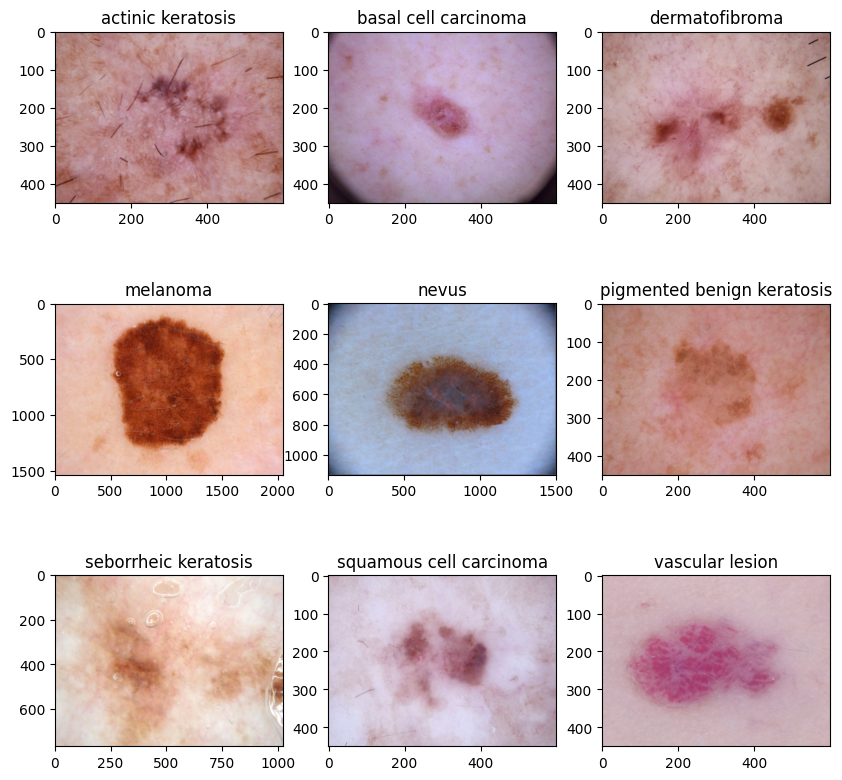

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 550s 2s/step - loss: 2.0576 - accuracy: 0.1802 - val_loss: 2.0378 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0118 - accuracy: 0.2204 - val_loss: 1.9855 - val_accuracy: 0.2483
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0413 - accuracy: 0.2098 - val_loss: 2.0620 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 91ms/step - loss: 2.0261 - accuracy: 0.2065 - val_loss: 2.0310 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0155 - accuracy: 0.2031 - val_loss: 2.0355 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 5s 91ms/step - loss: 2.0001 - accuracy: 0.2260 - val_loss: 1.9689 - val_accuracy: 0.2528
Epoch 7/20
56/56 [==============================] - 5s 89ms/step - loss: 2.0266 - accuracy: 0.2165 - val_loss: 2.0327 - val_accuracy: 0.1924
Epoch 8/20
56/56 [======

### Visualizing training results

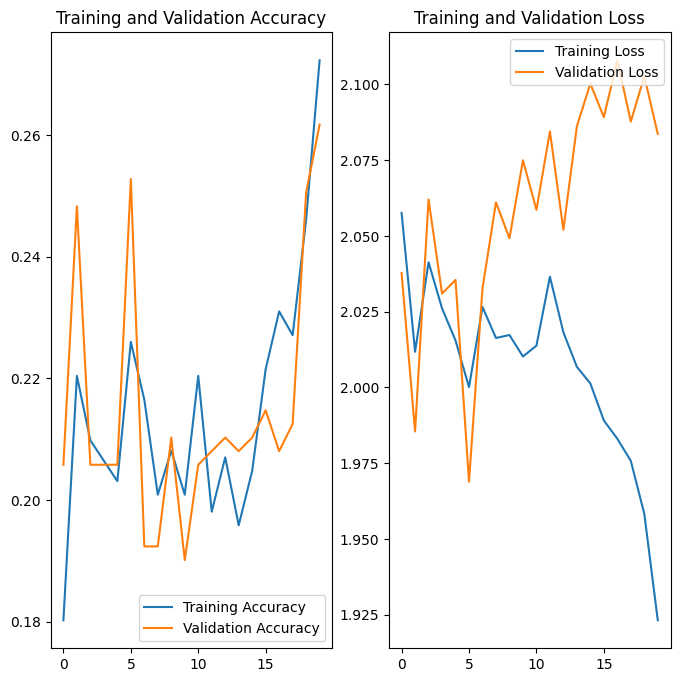

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Finding on the first base model

The accuracy is very low and loss is high.

The model is overfitting as training accuracy is high than validation accuracy.


In [17]:
# analysed the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

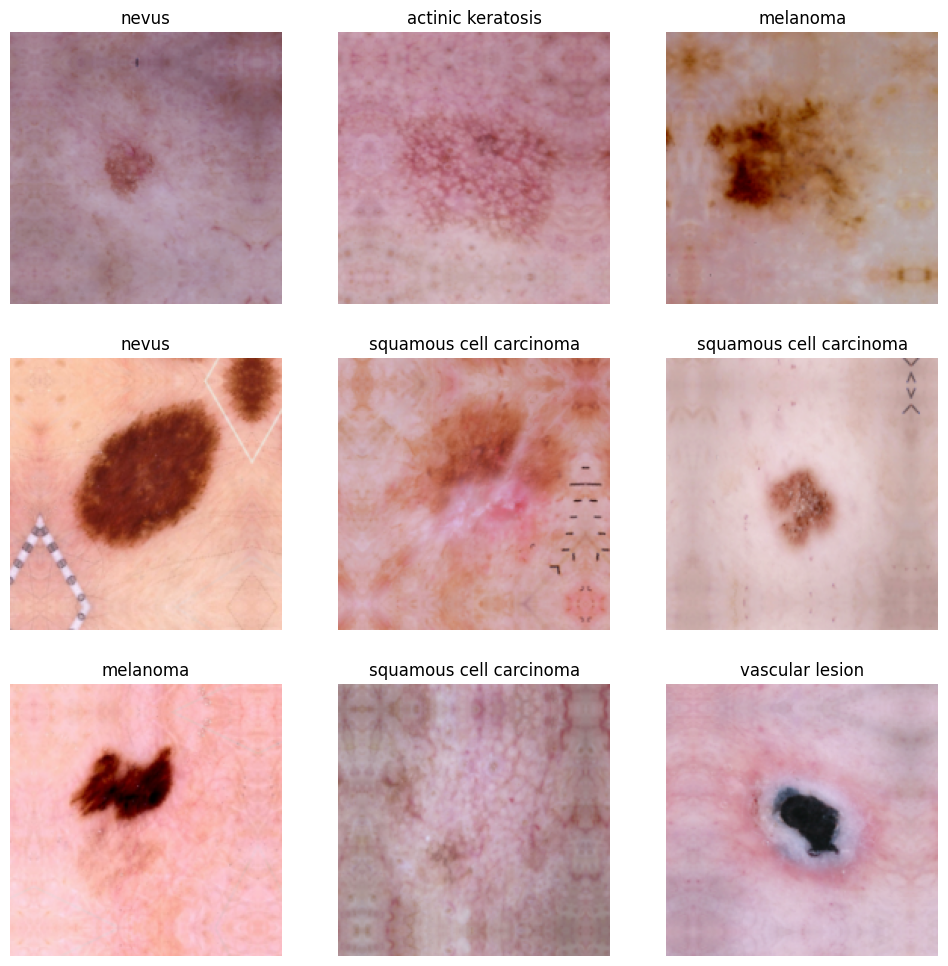

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 116ms/step - loss: 2.0551 - accuracy: 0.1892 - val_loss: 2.0066 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 6s 108ms/step - loss: 2.0045 - accuracy: 0.2478 - val_loss: 2.0148 - val_accuracy: 0.2192
Epoch 3/20
56/56 [==============================] - 6s 106ms/step - loss: 1.9366 - accuracy: 0.2511 - val_loss: 1.8632 - val_accuracy: 0.3177
Epoch 4/20
56/56 [==============================] - 6s 106ms/step - loss: 1.8100 - accuracy: 0.3320 - val_loss: 1.7310 - val_accuracy: 0.3333
Epoch 5/20
56/56 [==============================] - 6s 109ms/step - loss: 1.7839 - accuracy: 0.3393 - val_loss: 1.7836 - val_accuracy: 0.3535
Epoch 6/20
56/56 [==============================] - 6s 107ms/step - loss: 1.7637 - accuracy: 0.3622 - val_loss: 1.6546 - val_accuracy: 0.4139
Epoch 7/20
56/56 [==============================] - 6s 105ms/step - loss: 1.6792 - accuracy: 0.3862 - val_loss: 1.7221 - val_accuracy: 0.3557
Epoch

### Visualizing the results

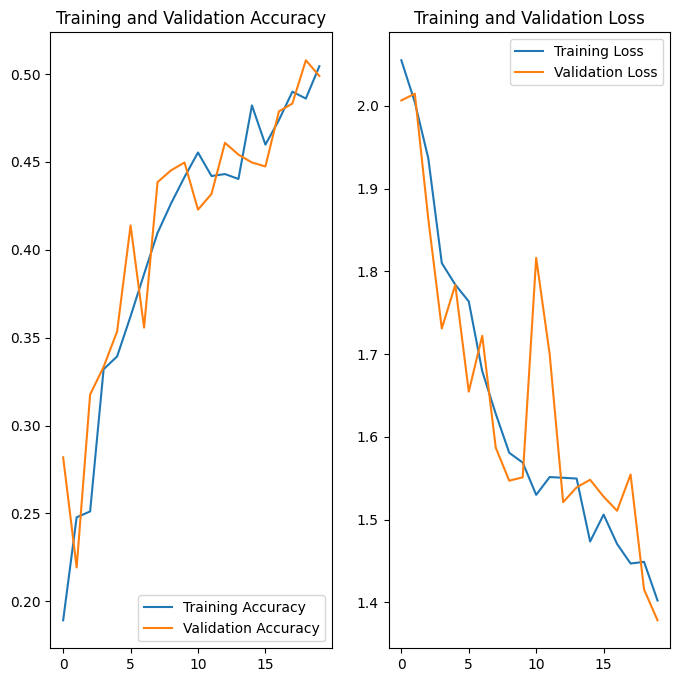

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Finding from Second Model

After adding dropouts, there is improvement in accuracy and overfitting is some what solved

We can try to increase the epochs to increase the accuracy score and it's too early for judgement.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/CNN_assi...,actinic keratosis
1,/content/drive/MyDrive/CNN_assignment/CNN_assi...,actinic keratosis
2,/content/drive/MyDrive/CNN_assignment/CNN_assi...,actinic keratosis
3,/content/drive/MyDrive/CNN_assignment/CNN_assi...,actinic keratosis
4,/content/drive/MyDrive/CNN_assignment/CNN_assi...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/CNN_assignment/CNN_assi...,vascular lesion
2235,/content/drive/MyDrive/CNN_assignment/CNN_assi...,vascular lesion
2236,/content/drive/MyDrive/CNN_assignment/CNN_assi...,vascular lesion
2237,/content/drive/MyDrive/CNN_assignment/CNN_assi...,vascular lesion


<BarContainer object of 9 artists>

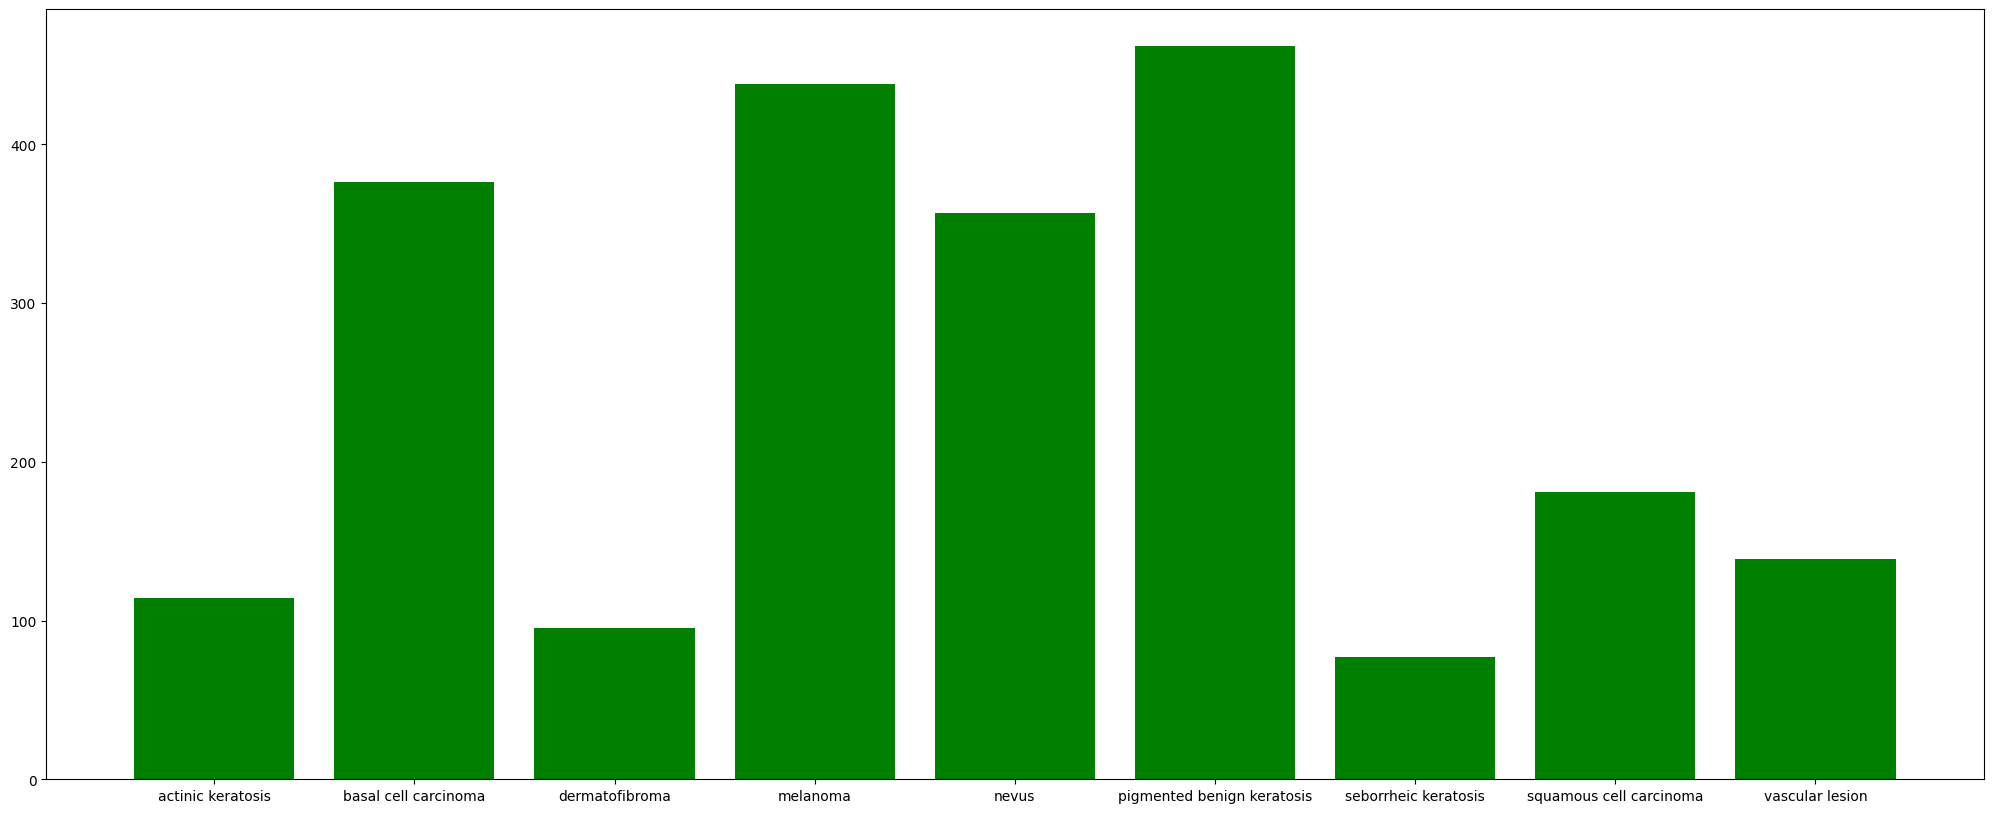

In [27]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count,color='green')

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

seborrheic keratosis has least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?

We can find that pigmented benign keratosis (with 462 images) and melanoma
 (with 438 images) classes dominate the data.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset='/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7869C820D960>: 100%|██████████| 500/500 [00:19<00:00, 25.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x786A303FB8B0>: 100%|██████████| 500/500 [00:19<00:00, 26.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x786A4B4A9CC0>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x786A4B4CE9E0>: 100%|██████████| 500/500 [01:27<00:00,  5.75 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x786A306B97B0>: 100%|██████████| 500/500 [01:14<00:00,  6.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786A307D4AF0>: 100%|██████████| 500/500 [00:22<00:00, 22.58 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x786A48198760>: 100%|██████████| 500/500 [00:40<00:00, 12.38 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7869C8EC89A0>: 100%|██████████| 500/500 [00:20<00:00, 24.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x786A304BB850>: 100%|██████████| 500/500 [00:18<00:00, 27.58 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new


['/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027506.jpg_28cc3a43-8c75-4efd-831c-d23b2f1444a7.jpg',
 '/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029582.jpg_5690f44f-39a8-4c98-8921-455c0e5ac77b.jpg',
 '/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027550.jpg_7caecb19-aba8-41e0-8ee7-2afa9b737090.jpg',
 '/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030991.jpg_759c0639-13bf-4f6f-b53c-41fa1bb94f24.jpg',
 '/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032349.jpg_d39adc34-6f15-427f-9bbb-5582959aa64f.jpg',
 '/content/drive/MyDrive/CNN_assignment/

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [47]:
# new_df['Label'].value_counts()
df2['Label'].value_counts()

Label
squamous cell carcinoma       500
basal cell carcinoma          500
nevus                         500
pigmented benign keratosis    500
melanoma                      500
actinic keratosis             500
dermatofibroma                500
vascular lesion               500
seborrheic keratosis          500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [49]:
data_dir_train="/content/drive/MyDrive/CNN_assignment/CNN_assignment_images/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [51]:
print('Count of training batches: %d' % tf.data.experimental.cardinality(train_ds).numpy())
print('Count of validation batches: %d' % tf.data.experimental.cardinality(val_ds).numpy())

Count of training batches: 169
Count of validation batches: 43


#### **Todo:** Create your model (make sure to include normalization)

In [53]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 batch_normalization_1 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [56]:
## Your code goes here, use 50 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 55s 304ms/step - loss: 5.1523 - accuracy: 0.3731 - val_loss: 8.5389 - val_accuracy: 0.0928
Epoch 2/30
169/169 [==============================] - 46s 264ms/step - loss: 3.6763 - accuracy: 0.4761 - val_loss: 5.3477 - val_accuracy: 0.1596
Epoch 3/30
169/169 [==============================] - 48s 275ms/step - loss: 3.0372 - accuracy: 0.5159 - val_loss: 3.6838 - val_accuracy: 0.3393
Epoch 4/30
169/169 [==============================] - 48s 274ms/step - loss: 2.2160 - accuracy: 0.5662 - val_loss: 4.6528 - val_accuracy: 0.4157
Epoch 5/30
169/169 [==============================] - 47s 269ms/step - loss: 1.3218 - accuracy: 0.6452 - val_loss: 1.1584 - val_accuracy: 0.6459
Epoch 6/30
169/169 [==============================] - 49s 283ms/step - loss: 0.8968 - accuracy: 0.7040 - val_loss: 0.9736 - val_accuracy: 0.6726
Epoch 7/30
169/169 [==============================] - 47s 271ms/step - loss: 0.8100 - accuracy: 0.7300 - val_loss: 0.8840 - val_accuracy: 0.7

#### **Todo:**  Visualize the model results

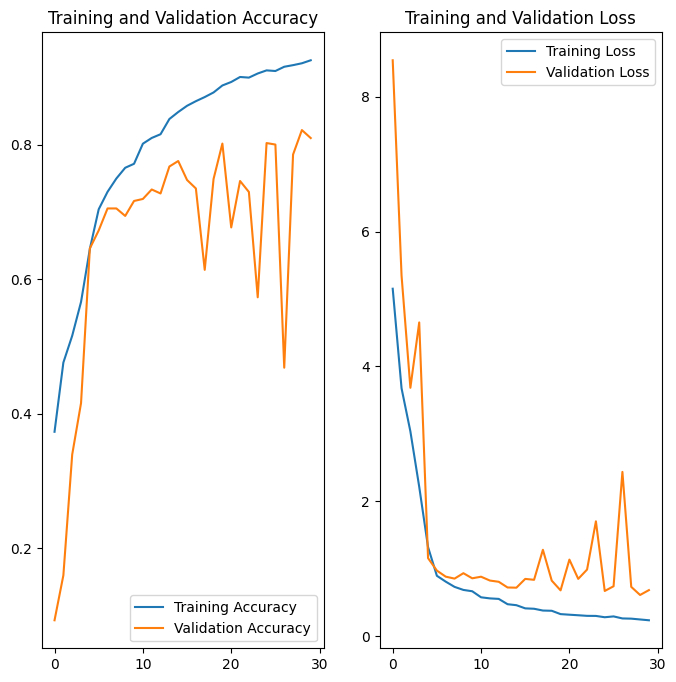

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The model gave very good training accuracy after using Augmentor library.

Augmentor was used to generate 500 images of each class so that class rebalance can be achieved.

The model is still overfitting but the training and validation losses has  reduced and are less than 1%.

The Model can be further improved by tuning the hyperparameters.
